# Photoionization of $V_3$

In this notebook we use a more sophisticated program, which is written in C++, to calculate FCFs for various molecules. The program is located under "common/FC" in the repository, and the main file for compilation and execution is the file `FC.cxx`. After compiling and runing the code for "V3" we have stored the output files under `common/FC/output`. Let us plot the results. As we know the file `V3.sticks.out` contains the spectrum as sticks (i.e. it just contains the position and height of maximums), while the file `V3.spec.out` contains the Lorentzian smoothed version of the spectrum.

First let us import necessary python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common.utils import dump_frequency_analysis

Now we import the files `V3.sticks.out` and `V3.spec.out` into numpy arrays, so that we can plot them.

In [2]:
sticks = np.loadtxt("common/FC/output/V3.sticks.out", delimiter=" ")
spec = np.loadtxt("common/FC/output/V3.spec.out", delimiter="  ")

Now, it's time to plot!

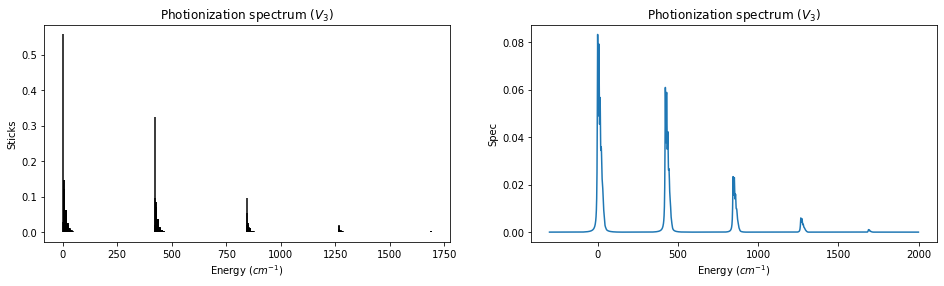

In [4]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.vlines(sticks[:, 0], 0, sticks[:, 1])
plt.title('Photionization spectrum ($V_3$)')
plt.xlabel('Energy ($cm^{-1}$)')
plt.ylabel('Sticks')

plt.subplot(1, 2, 2)
plt.plot(spec[:, 0], spec[:, 1])
plt.title('Photionization spectrum ($V_3$)')
plt.xlabel('Energy ($cm^{-1}$)')
plt.ylabel('Spec')

plt.show()

## Challenge 2


In this notebook so far we have used a pre generated file called "V3", which contains some information about the molecule which is used by the code `FC.cxx` to do the calculations. What if we need to calculate Franck-Condon factors for other molecules? We need to be able to generate input files like `V3` to feed into `FC.cxx`. The specification of the file is available at `common/FC/fileformat.txt`. To generate a file like `V3` for some molecule, we need to 
1. Get the geometry of the molecule
2. Calculate the hamiltonian and the Hessian matrix
3. Calculate the vibrational eigenvalues and modes from the Hessian

We will use the `pyscf` python library for computational chemistry to do these calculations.

Let us define a function, which takes as argument the geometry specification of a molecule and the corresponding cation, and returns the information about normal modes (the wavenumbers, mode functions, and more).

In [1]:
from pyscf import gto, dft
from pyscf.hessian.thermo import harmonic_analysis

def calculade_normal_modes(geomn, geomc, basis='sto=3g', max_cycle=50):
    # Create Molecule objects
    moln = gto.M(atom=geomn, basis=basis, charge=0, spin=None)
    mfn = moln.UKS(max_cycle=max_cycle).run()
    
    molc = gto.M(atom=geomc, basis=basis, charge=1, spin=None)
    mfc = molc.UKS(max_cycle=max_cycle).run()

    # Calculate Hessians
    hessn = mfn.Hessian().kernel()
    hessc = mfc.Hessian().kernel()

    # Frequency analysis
    freq_infon = harmonic_analysis(mfn.mol, hessn)
    freq_infoc = harmonic_analysis(mfc.mol, hessc)
    
    return freq_infon, freq_infoc

Before running the program for a new molecule, let us verify that it gives correct results for $V_3$. For that, we copy the geometry specification of theis molecule from the file "V3" and generate the rest of the information in the file using the function defined above.

In [2]:
GEOM_V3_NEUTRAL = [
    ['V', .000000,    .000000, -1.252248],
    ['V', .000000,  -1.084004,   .626124],
    ['V', .000000,   1.084004,   .626124]]
GEOM_V3_CATION = [
    ['V', .000000,     .000000,   -1.276907],
    ['V', .000000,   -1.105517,     .638454],
    ['V', .000000,    1.105517,     .638454]]

freq_infon, freq_infoc = calculade_normal_modes(GEOM_V3_NEUTRAL, GEOM_V3_CATION, basis='cc-pvdz', max_cycle=100)

converged SCF energy = -2825.55549578795  <S^2> = 0.98383463  2S+1 = 2.2215622
converged SCF energy = -2825.33788937465  <S^2> = 1.5246164  2S+1 = 2.6642945


And let us write the results into a file:

In [ ]:
dump_frequency_analysis('common/FC/V3new', GEOM_V3_NEUTRAL, GEOM_V3_CATION, freq_infon, freq_infoc, moln.atom_mass_list())  

So, now we can turn to looking at new molecules to generate input files for `FC.cxx`. As an example, let us consider the Ammonia molecule ($NH_3$). This molecule is interesting in many regards, but the most interesting part of it is, that it undergoes large geometrical changes when photoionizaion accurs (from 3D structure it even becomes a plane structure), so this is a good testbed for the theories and calculations used in this project. Can the harmonic oscillation approximation still predict the properties of this molecule correctly? The photoionization properties of $NH_3$ have been investigated heavily, both experimentally and theoretically (see https://doi.org/10.1021/jp905004z). After we do our calculations below we will be able to verify the results and the accuracy of our methods.

One option to obtain the molecule's equilibrium geometry is to calculate it using e.g. the geomopt (geometry optimization) tool from pyscf, however, to save some time, we will just use the pre-calculated geometries from the NIST database (https://cccbdb.nist.gov/geom1x.asp).

For the numerical calculations we will use the basis set `631++g` as recomended in the paper cited above.

In [3]:
GEOM_NH3_NEUTRAL = [
    ['N',  0.0000,  0.0000,  0.0000],
    ['H',  0.0000, -0.9377, -0.3816],
    ['H',  0.8121,  0.4689, -0.3816],
    ['H', -0.8121,  0.4689, -0.3816]]

GEOM_NH3_CATION = [
    ['N',  0.0000,  0.0000, 0.0000],
    ['H',  0.0000,  1.0091, 0.0000],
    ['H',  0.8739, -0.5046, 0.0000],
    ['H', -0.8739, -0.5046, 0.0000]]

freq_infon, freq_infoc = calculade_normal_modes(GEOM_NH3_NEUTRAL, GEOM_NH3_CATION, basis='631++g', max_cycle=50)

Now we can write the results into a file which can be recognized by `FC.cxx` (a file analogous to "V3")

In [5]:
dump_frequency_analysis('common/FC/NH3', GEOM_NH3_NEUTRAL, GEOM_NH3_CATION, freq_infon, freq_infoc, moln.atom_mass_list())   

Let us print out the wavenumbers of the normal modes for the $NH_3$ and $NH_3^+$, so that we can compare them with the theoretical and experimental results in the cited article above. As we can see the results are pretty close (please refer to the cited article).

In [6]:
print(freq_infon['freq_wavenumber'])
print(freq_infoc['freq_wavenumber'])

[ 993.41159989 1655.77908018 1655.86402162 3560.65054354 3716.19262115
 3716.57077157]
[ 763.75537418 1469.2659281  1469.4289057  3588.28456208 3795.66098483
 3795.85280154]
